# Multivariate LSTM

A multivariate LSTM is used to predict the price of the stock in this section. In general stocks are highly affected by external factors and therefore this complexity is ignored when a regular LSTM model, that only takes previously stock-price, into account.
Eventhough multivariate doesn't fully grasps the compleksity of this, it does a better job.

# multistep



Multistep-ahead prediction is the task of predicting a sequence of values in a time series. A typical approach, known as multi-stage prediction, is to apply a predictive model step-by-step and use the predicted value of the current time step to determine its value in the next time step

## Data pre-processing

## 

In [1]:
import pandas as pd
import numpy as np

In [2]:
#import input data
news = pd.read_csv(r"I:\python_file\save\M4 (1)\Sentiment Analysis\News_combined.csv", index_col=0)
stock = pd.read_csv(r"I:\python_file\save\M4 (1)\Stock data\Phizer.csv", index_col=0)
news = news.set_index('Date')
#merge the data and drop na rows
df_input = stock.merge(news, left_index=True, right_index=True).dropna()

#df_input = df_input[(df_input.index > '2019-06-01')]

In [3]:
df_input

,Open,High,Low,Close,Adj Close,Volume,Daily Return,positiv,neutral,negativ
Date,,,,,,,,,,
2017-03-06,32.571156,32.703983,32.333965,32.590134,27.264444,19174263,-0.004925,1,0.0,0.0
2017-03-10,32.390892,32.561668,32.258064,32.362431,27.073948,20214666,0.001762,1,0.0,1.0
2017-03-13,32.390892,32.400379,32.172676,32.362431,27.073948,19988056,0.000000,1,0.0,0.0
2017-03-14,32.277039,32.571156,32.239090,32.466793,27.161261,15563469,0.003225,1,0.0,1.0
2017-03-16,32.798862,32.855785,32.495255,32.666035,27.327942,21816219,-0.005775,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-12-08,52.750000,53.080002,51.029999,51.400002,51.400002,37429200,-0.006187,7,16.0,2.0
2021-12-09,51.509998,52.849998,51.509998,52.080002,52.080002,38325700,0.013230,5,12.0,0.0
2021-12-10,51.200001,52.849998,51.110001,52.779999,52.779999,26043000,0.013441,10,3.0,2.0


Creating a new dataframe, that will be our feature list

In [4]:
df_filter = df_input.filter(['Daily Return', 'positiv', 'negativ', 'neutral', 'Close'])

In [5]:
df_filter

,Daily Return,positiv,negativ,neutral,Close
Date,,,,,
2017-03-06,-0.004925,1,0.0,0.0,32.590134
2017-03-10,0.001762,1,1.0,0.0,32.362431
2017-03-13,0.000000,1,0.0,0.0,32.362431
2017-03-14,0.003225,1,1.0,0.0,32.466793
2017-03-16,-0.005775,1,0.0,0.0,32.666035
...,...,...,...,...,...
2021-12-08,-0.006187,7,2.0,16.0,51.400002
2021-12-09,0.013230,5,0.0,12.0,52.080002
2021-12-10,0.013441,10,2.0,3.0,52.779999


In [6]:
# the index is reset, so the date is now not the index any more.
df_filter = df_filter.reset_index(drop=False)

In [7]:
df_filter

,Date,Daily Return,positiv,negativ,neutral,Close
0,2017-03-06,-0.004925,1,0.0,0.0,32.590134
1,2017-03-10,0.001762,1,1.0,0.0,32.362431
2,2017-03-13,0.000000,1,0.0,0.0,32.362431
3,2017-03-14,0.003225,1,1.0,0.0,32.466793
4,2017-03-16,-0.005775,1,0.0,0.0,32.666035
...,...,...,...,...,...,...
681,2021-12-08,-0.006187,7,2.0,16.0,51.400002
682,2021-12-09,0.013230,5,0.0,12.0,52.080002
683,2021-12-10,0.013441,10,2.0,3.0,52.779999
684,2021-12-13,0.045851,2,2.0,1.0,55.200001


In [8]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
#from tensorflow.keras.callbacks import EarlyStopping


%matplotlib inline

next the traing data is selected as the featurelist (from above) is chossen. in the output the feature list can now be seen.

also the shape of the data can be seen in the output, which in this case is the same as timestamps.

In [12]:
# Importing Training Set
dataset_train = df_filter

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (686, 6)
All timestamps == 686
Featured selected: ['Daily Return', 'positiv', 'negativ', 'neutral', 'Close']


In [13]:
#Removing all commas and convert data to matrix format (to_numpy):
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (686, 5).


array([[-4.92469108e-03,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.25901337e+01],
       [ 1.76208494e-03,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  3.23624306e+01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.23624306e+01],
       ...,
       [ 1.34408011e-02,  1.00000000e+01,  2.00000000e+00,
         3.00000000e+00,  5.27799988e+01],
       [ 4.58507397e-02,  2.00000000e+00,  2.00000000e+00,
         1.00000000e+00,  5.52000008e+01],
       [ 6.15942297e-03,  3.00000000e+00,  1.00000000e+00,
         4.00000000e+00,  5.55400009e+01]])

Next the data is scaled to make it more suitable for the deep learning model. This is because the variables are on different scales, so we need to scale them to get the variables on the same scale.

In [14]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-3.99909648e-01],
       [ 1.82751436e-02],
       [-9.19240198e-02],
       [ 1.09762689e-01],
       [-4.53099476e-01],
       [-2.91731828e-01],
       [-1.28523224e-01],
       [-5.54803472e-02],
       [-2.38273598e-01],
       [-1.10261178e-01],
       [-5.48519847e-02],
       [ 7.47857262e-02],
       [ 1.88890651e-02],
       [-3.50042360e-01],
       [-1.48665325e-01],
       [ 1.16469571e-01],
       [-7.46997837e-01],
       [-5.29848196e-02],
       [ 1.22716275e-01],
       [-1.30824041e-01],
       [-2.28426021e-01],
       [-5.80510185e-01],
       [ 2.13047450e-01],
       [ 3.82292163e-01],
       [ 1.10049618e-01],
       [-3.29837480e-01],
       [-5.87980978e-01],
       [-3.14288725e-01],
       [-1.66310076e-01],
       [ 3.36308479e-01],
       [-4.24782881e-01],
       [ 1.52806533e-01],
       [ 3.95478481e-01],
       [-3.90796879e-01],
       [ 1.92338888e-01],
       [-7.30481321e-02],
       [-2.42813739e-01],
       [ 3.00931843e-01],
       [-7.0

next we determine the x-train and y_train data.

Also we determine how many days into the future we wish to predict the price of the stock ('n_tuture')
and we determine how many previous days, we need to predict the next ('n_past')

In [15]:
# Creating a data structure with 30 timestamps and 1 output
X_train = []
y_train = []

n_future = 30   # Number of days we want top predict into the future
n_past = 30     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (627, 30, 4).
y_train shape == (627, 1).


here we see the shape of the data and see that there are 1 output variable, which is the pct change in the stock price

## Create a model + training

In [16]:
# Import Libraries and packages from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

below we initialize the model as a sequential model meaning it's a stack of layers, using previous observations to predict the next.


In [17]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding Dropout
model.add(Dropout(0.2))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Dense layer
model.add(Dense(units=5, activation='linear'))

# Adding Dropout
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

Next the model is trained.

In [18]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=100, verbose=1) 
#rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1) 
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

#history = model.fit(X_train, y_train, shuffle=True, epochs=1000, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)
history = model.fit(X_train, y_train, shuffle=True, epochs=1000, callbacks=[es, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

#Early stopping: stops training when a monitered matric has stopped improving
#monitor: quantity to be monitered - validation loss in this case
#min_delta: minimum change in the monitred quantity (validation loss) to qualify as an improvement.
#patience: number of epochs with no improvement after wich training will stop
#ReduceLR0nPlateau: reduce learning rate when a matric has stopped improve
#factor: factor by which the learning rate will be reduced

Epoch 1/1000
1/2 [==============>...............] - ETA: 5s - loss: 1.1407
Epoch 00001: val_loss improved from inf to 1.43883, saving model to weights.h5
2/2 [==============================] - 6s 669ms/step - loss: 1.0950 - val_loss: 1.4388
Epoch 2/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.0197
Epoch 00002: val_loss did not improve from 1.43883
2/2 [==============================] - 0s 42ms/step - loss: 0.9909 - val_loss: 1.4583
Epoch 3/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.9446
Epoch 00003: val_loss did not improve from 1.43883
2/2 [==============================] - 0s 39ms/step - loss: 0.9942 - val_loss: 1.4498
Epoch 4/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.9337
Epoch 00004: val_loss did not improve from 1.43883
2/2 [==============================] - 0s 40ms/step - loss: 0.9882 - val_loss: 1.4444
Epoch 5/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.0667
Epoch 00005: val_loss did not improve from 1.438

## Make future predictions (multistep-sequence)

In this section the model is used to predict a sequence of future stock-prices.

In [19]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [20]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [21]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Daily Return']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Daily Return']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head()

,Daily Return
2018-02-08,0.001733
2018-02-13,0.002563
2018-02-16,0.001970
2018-02-23,0.000563
2018-02-27,0.000185


In [22]:
#START_DATE_FOR_PLOTTING

below is the list of the future predictions

In [23]:
PREDICTIONS_FUTURE

,Daily Return
2021-12-14,-0.001412
2021-12-15,-0.004455
2021-12-16,0.003745
2021-12-17,0.006503
2021-12-18,-0.002161
2021-12-19,-0.000671
2021-12-20,0.020127
2021-12-21,0.004974
2021-12-22,0.025167
2021-12-23,0.002856


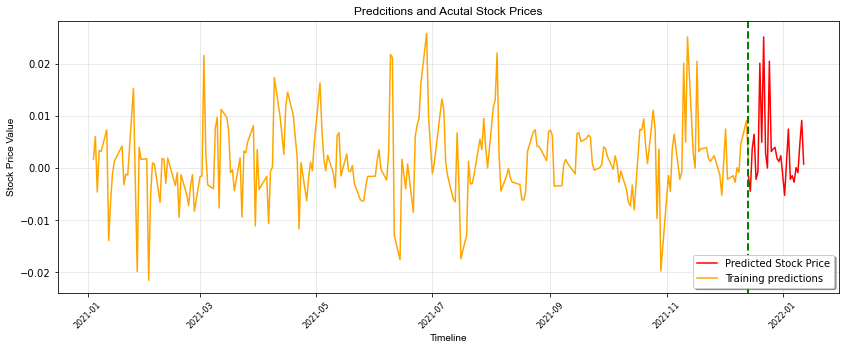

In [24]:
#### WE DON'T USE THIS PLOT - BUT KEEPS THE CODE ####

# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2021-01-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Daily Return'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Daily Return'], color='orange', label='Training predictions')
#plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Daily Return'], color='b', label='Actual Stock Price')
plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [25]:
#This is the start date for the below plot:
START_DATE_FOR_PLOTTING = '2021-01-01'

In [26]:
#Need to do some data manipulation to get actual stock price into plot:
actual_price_1=df_input.loc[START_DATE_FOR_PLOTTING:].index, df_input.loc[START_DATE_FOR_PLOTTING:]['Daily Return']#getting data from the historical preiod
actual_price_2=np.transpose(actual_price_1)#transposing the data structure in the ndarray
actual_price_3 = pd.DataFrame(actual_price_2, columns = ['date','Daily Return']) #converting from ndarray to pandas dataframe, the same as the other variables
actual_price_3['date'] = pd.to_datetime(actual_price_3['date']) #converting date-object into datetime-format, the same as the other variables
actual_price_4= actual_price_3.set_index('date') #setting the date as index, the same as the other variables
actual_price_5=actual_price_4.loc[START_DATE_FOR_PLOTTING:]['Daily Return'] #chossing only from the start date

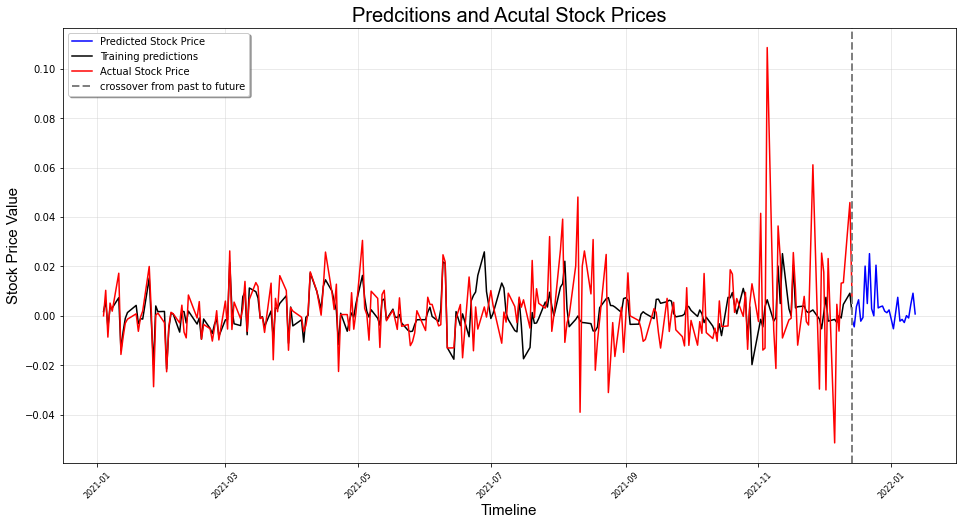

In [27]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

# Plot parameters
START_DATE_FOR_PLOTTING = START_DATE_FOR_PLOTTING

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Daily Return'], color='blue', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Daily Return'], color='black', label='Training predictions')
plt.plot(actual_price_5, color='red', label='Actual Stock Price')
plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='grey', linewidth=2, linestyle='--', label='crossover from past to future')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=20)
plt.xlabel('Timeline', family='Arial', fontsize=15)
plt.ylabel('Stock Price Value', family='Arial', fontsize=15)
plt.xticks(rotation=45, fontsize=8)
plt.show()

Here we see the predicted stock price both previously and in the future and also how theese compare to the actual stock price.

# Backtesting

In [33]:
predictions_train

array([[ 1.64732877e-02],
       [ 6.83604181e-02],
       [ 3.12490743e-02],
       [-5.67271784e-02],
       [-8.03485811e-02],
       [-1.67697463e-02],
       [ 1.09126918e-01],
       [ 1.29783139e-01],
       [ 1.56995967e-01],
       [-2.48216037e-02],
       [-4.56809849e-02],
       [ 1.30843297e-01],
       [ 3.47645074e-01],
       [ 2.26770833e-01],
       [ 2.00796518e-02],
       [-6.84233904e-02],
       [ 9.67031810e-04],
       [-1.01738803e-01],
       [-1.73455656e-01],
       [-1.94704592e-01],
       [-1.97964758e-01],
       [-1.93816364e-01],
       [-2.66250819e-01],
       [-2.15347156e-01],
       [-1.13653913e-01],
       [-1.13818482e-01],
       [-1.23572901e-01],
       [-2.87902862e-01],
       [-1.84161738e-01],
       [-1.26286939e-01],
       [-1.51280127e-03],
       [-1.04783308e-02],
       [-1.64620563e-01],
       [-1.54719278e-01],
       [-1.75955161e-01],
       [-1.03316255e-01],
       [-8.93372521e-02],
       [-2.07209617e-01],
       [-1.8

In [28]:
df_input1 = df_input.copy()

In [29]:
predicted_close = PREDICTION_TRAIN.copy()
predicted_close.index = predicted_close.index.strftime('%Y-%m-%d')
predicted_close.columns = ['Predict_close']
#backtest_df_temp = df_input1.filter(['Open', 'High', 'Low','Close','Adj Close', 'Volume','Daily Return'])
backtest_df_temp = df_input1.filter(['Adj Close'])
backtest_df = pd.merge(backtest_df_temp, predicted_close, left_index=True, right_index=True)
backtest_df.to_csv("LSTM_Multistep_label.csv")

In [34]:
backtest_df

,Adj Close,Predict_close
2018-02-08,27.717697,0.001733
2018-02-13,28.797396,0.002563
2018-02-16,29.885340,0.001970
2018-02-23,29.885340,0.000563
2018-02-27,30.330399,0.000185
...,...,...
2021-12-08,51.400002,0.000084
2021-12-09,52.080002,-0.000873
2021-12-10,52.779999,0.004637
2021-12-13,55.200001,0.009157


In [30]:
#backtest_test = backtest_df.groupby(level=0).mean()
#backtest_test.index.value_counts()
#backtest_test.to_csv("backtest_test.csv")

In [31]:
backtest_df.index.value_counts()

2018-02-08    1
2021-02-22    1
2021-02-24    1
2021-02-25    1
2021-02-26    1
             ..
2020-03-16    1
2020-03-17    1
2020-03-18    1
2020-03-19    1
2021-12-14    1
Length: 597, dtype: int64

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=520f7743-fdb5-41d4-ba65-deb67c6338e8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>